In [57]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [58]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data() # 返回的data就是pd格式的数据类型

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month # time_idx变量很重要，后面都要使用
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [59]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=1)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=1)

创建基线模型，基线模型就是简单地将最近观测道德值作为未来6个月的预测结果

In [60]:
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

C:\Users\a\anaconda3\envs\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\a\anaconda3\envs\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


293.0088195800781

In [61]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
C:\Users\a\anaconda3\envs\venv\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


C:\Users\a\anaconda3\envs\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\a\anaconda3\envs\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at D:\MyProject\TFT\.lr_find_46596c38-4039-4d0d-994b-8067df44a73a.ckpt


suggested learning rate: 0.01862087136662867


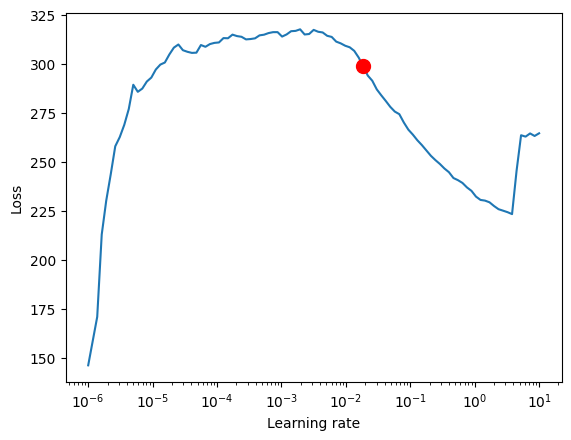

C:\Users\a\AppData\Local\Temp\ipykernel_15868\2247737331.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [62]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [63]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

C:\Users\a\anaconda3\envs\venv\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


C:\Users\a\anaconda3\envs\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\a\anaconda3\envs\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:268: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [64]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Missing logger folder: lightning_logs\lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\a\anaconda3\envs\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "C:\Users\a\anaconda3\envs\venv\lib\multiprocessing\queues.py", line 235, in _feed
    close()
  File "C:\Users\a\anaconda3\envs\venv\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "C:\Users\a\anaconda3\envs\venv\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] 句柄无效。

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\a\anaconda3\envs\venv\lib\threading.p

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [2]:
a = 1
b = 2
c = a or b
c

1

In [5]:
import numpy as np
c = np.random.rand(30) - 0.5
print(c)

[-0.49604261  0.23810616  0.4473159   0.02553372 -0.22499214 -0.43720962
  0.44986829  0.49981462  0.00531959 -0.12746346  0.11686006 -0.15548824
  0.23825576  0.08972241 -0.2959239  -0.27528163  0.29037345 -0.31352057
  0.40412053  0.39102827  0.43830443  0.29759509  0.0770296  -0.25419869
  0.00590814 -0.48548133  0.11700124  0.48964295 -0.35764881 -0.08795071]


In [6]:
np.repeat(np.arange(3), 10)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2])

In [7]:
import numpy as np
import pandas as pd

test_data = pd.DataFrame(
    dict(
        value=np.random.rand(30) - 0.5,
        group=np.repeat(np.arange(3), 10),
        time_idx=np.tile(np.arange(10), 3)
    )
)

In [8]:
from pytorch_forecasting import TimeSeriesDataSet
dataset = TimeSeriesDataSet(
    test_data,
    group_ids=["group"],
    target="value",
    time_idx="time_idx",
    min_encoder_length=5,
    max_encoder_length=5,
    min_prediction_length=2,
    max_prediction_length=2,
    time_varying_unknown_reals=["value"]
)

In [9]:
dataset.get_parameters()

{'time_idx': 'time_idx',
 'target': 'value',
 'group_ids': ['group'],
 'weight': None,
 'max_encoder_length': 5,
 'min_encoder_length': 5,
 'min_prediction_idx': 0,
 'min_prediction_length': 2,
 'max_prediction_length': 2,
 'static_categoricals': [],
 'static_reals': [],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': [],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['value'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': False,
 'target_normalizer': GroupNormalizer(
 	method='standard',
 	groups=[],
 	center=True,
 	scale_by_group=False,
 	transformation=None,
 	method_kwargs={}
 ),
 'categorical_encoders': {'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True),
  'group': NaNLabelEncoder(add_nan=False, warn=True)},
 'scalers': {},
 'randomize_length': None,
 'predict_mode': False}

In [10]:
dataloader = dataset.to_dataloader(batch_size=4)

x, y = next(iter(dataloader))
print("x=", x)
print("\ny = ", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

x= {'encoder_cat': tensor([], size=(4, 5, 0), dtype=torch.int64), 'encoder_cont': tensor([[[-0.8307],
         [-0.6007],
         [-0.5853],
         [ 0.1155],
         [ 1.3908]],

        [[-0.5237],
         [-0.9083],
         [ 0.9925],
         [ 0.8076],
         [-1.6073]],

        [[ 0.3562],
         [-0.8307],
         [-0.6007],
         [-0.5853],
         [ 0.1155]],

        [[-0.6571],
         [-0.2643],
         [ 1.3029],
         [-1.5070],
         [ 0.6643]]]), 'encoder_target': tensor([[-0.2380, -0.1682, -0.1635,  0.0493,  0.4365],
        [-0.1448, -0.2616,  0.3156,  0.2594, -0.4739],
        [ 0.1224, -0.2380, -0.1682, -0.1635,  0.0493],
        [-0.1853, -0.0661,  0.4098, -0.4434,  0.2159]]), 'encoder_lengths': tensor([5, 5, 5, 5]), 'decoder_cat': tensor([], size=(4, 2, 0), dtype=torch.int64), 'decoder_cont': tensor([[[ 1.4975],
         [ 0.6476]],

        [[ 0.0999],
         [ 1.0531]],

        [[ 1.3908],
         [ 1.4975]],

        [[-1.1343],
    

In [11]:
c = torch.tensor([], size=(4, 5, 0), dtype=torch.int64)
c

NameError: name 'torch' is not defined

In [12]:
import torch
c = torch.tensor([], size=(4, 5, 0), dtype=torch.int64)
c

TypeError: tensor() got an unexpected keyword argument 'size'

In [13]:
c = dataset.index
c

,time_first,time_last,time_diff_to_next,index_start,time,count,sequence_id,index_end,sequence_length
0,0,9,1,0,0,10,0,6,7
1,0,9,1,1,1,10,0,7,7
2,0,9,1,2,2,10,0,8,7
3,0,9,1,3,3,10,0,9,7
10,0,9,1,10,0,10,1,16,7
11,0,9,1,11,1,10,1,17,7
12,0,9,1,12,2,10,1,18,7
13,0,9,1,13,3,10,1,19,7
20,0,9,1,20,0,10,2,26,7
21,0,9,1,21,1,10,2,27,7


In [14]:
data.loc[dataset.index, "target"]

NameError: name 'data' is not defined

In [15]:
probabilities = np.sqrt(1 + data.loc[dataset.index, "target"])

NameError: name 'data' is not defined